In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# 데이터셋을 저장할 디렉토리 지정
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT, 
                            train=True,
                            download=True)

In [4]:
# 정규화
mean = train_data.data.float().mean() /255
std = train_data.data.float().std() / 255

print(mean)
print(std)

tensor(0.1307)
tensor(0.3081)


In [5]:
# RandomRotation(5): 이미지를 -5+5 도 사이에서 임의로 회전
# RandomCrop : padding 2 추가 후, 28x28 crop
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [6]:
train_transforms

Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=(0,))
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)

In [7]:
test_transforms

Compose(
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)

In [8]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

print(len(train_data))
print(len(test_data))

60000
10000


In [9]:
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28,28).cpu().numpy(), cmap='bone')
        ax.axis('off')

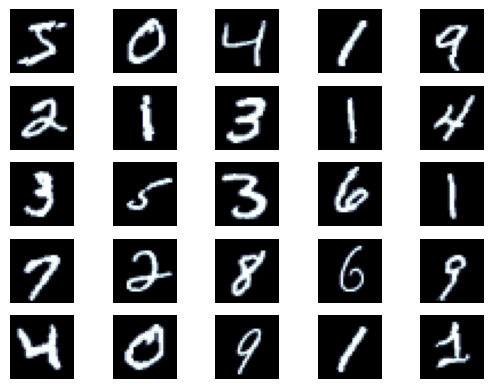

In [10]:
N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [11]:
# vallidataion 10% 지정
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [12]:
# train:validataion 9:1
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

print(len(train_data))
print(len(valid_data))
print(len(test_data))


54000
6000
10000


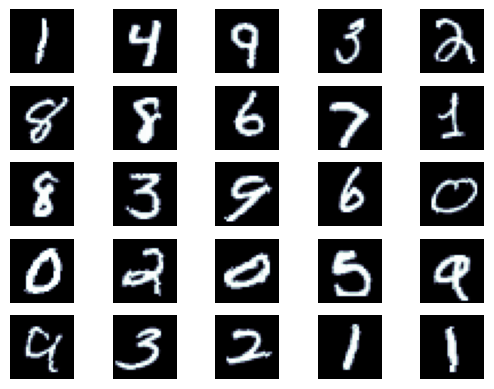

In [13]:
N_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

In [14]:
valid_data = copy.deepcopy(valid_data) # 깊은 복사
valid_data.dataset.transform = test_transforms

In [15]:
valid_data

In [16]:
valid_data.dataset.transform
# To double check we've correctly replaced the training transforms,
#  we can view the same set of images and notice how they're more central (no random cropping) 
# and have a more standard orientation (no random rotations).


Compose(
    ToTensor()
    Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
)

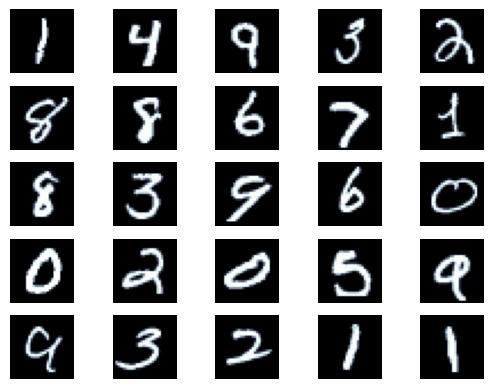

In [17]:
N_IMAGES2 = 25
images2 = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images2)

In [18]:
images2

[tensor([[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.424

In [19]:
BATCH_SIZE = 64
# dataloader 미니배치 생성
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)


In [25]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2


In [26]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model  = MLP(INPUT_DIM, OUTPUT_DIM)

In [27]:
model

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)

In [28]:
# We can also create a small function to clculate the number of trainable paramters (weights and biases) in our model.
# in case all of our parameterrs are trainable.

In [29]:
# nume1() 텐서의 사이즈
# requires_grad = True 자동미분
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

222360


In [30]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [31]:
model

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)

In [33]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [34]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    # tqdm progres bar function, leave 반복 완료시 출력 여부
    for (x,y) in tqdm(iterator, desc='Traning', leave=False):
#                      반복                    
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() # 경사초기화
        y_pred, _ = model(x) # 순전파
        loss = criterion(y_pred, y) # 손실
        acc = calculate_accuracy(y_pred, y) #정확도

        loss.backward() # 역전파
        optimizer.step() # 역전파 수정

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [38]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval() #추론모드
    with torch.no_grad(): # 자동 미분 x
        for (x,y) in tqdm(iterator, desc='Evaluating', leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
EPOCHS = 3
best_valid_loss = float('inf') #양의 무한대(최대값으로 설정)
for epoch in trange(EPOCHS):
    start_time = time.monotonic() # 운영체제가 부팅된 이후의 시간(단조시간)

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train ACC: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. ACC: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.058 | Train ACC: 98.15%
	Val. Loss: 0.077 | Val. ACC: 97.47%


Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.047 | Train ACC: 98.42%
	Val. Loss: 0.080 | Val. ACC: 97.49%


Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.041 | Train ACC: 98.65%
	Val. Loss: 0.085 | Val. ACC: 97.51%



In [41]:
# 학습이 완료된 모형 
model.load_state_dict(torch.load('mlp-model.pt'))
test_loss, test_acc  = evaluate(model, test_iterator, criterion, device)

In [42]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.068 | Test Acc: 97.78%


In [43]:
def get_predictions(model, iterator, device):
    model.eval() # 추론 모드

    images = []
    labels = []
    probs = []

    with torch.no_grad(): # 미분 x 
        for (x, y ) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0) # 텐서 연결, dim=0 세로 방향, dim = 1 가로방향
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [45]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

In [46]:
pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

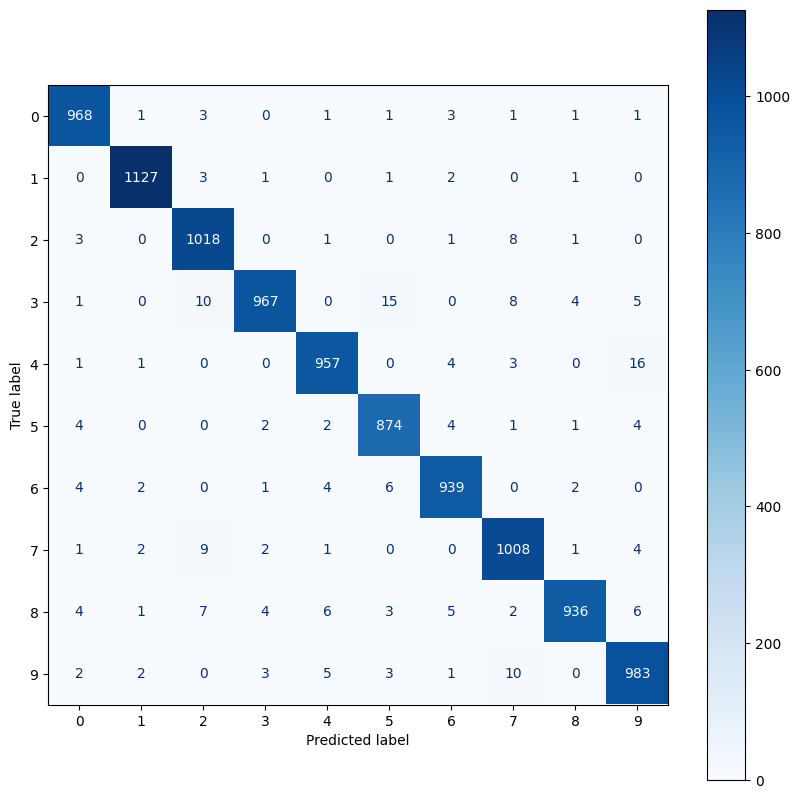

In [47]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels) 

In [48]:
# 실제값과 일치하는지 확인
corrects = torch.eq(labels, pred_labels)

In [49]:
corrects

tensor([True, True, True,  ..., True, True, True])

In [50]:
# 오차가 큰 출력값 정리
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [53]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

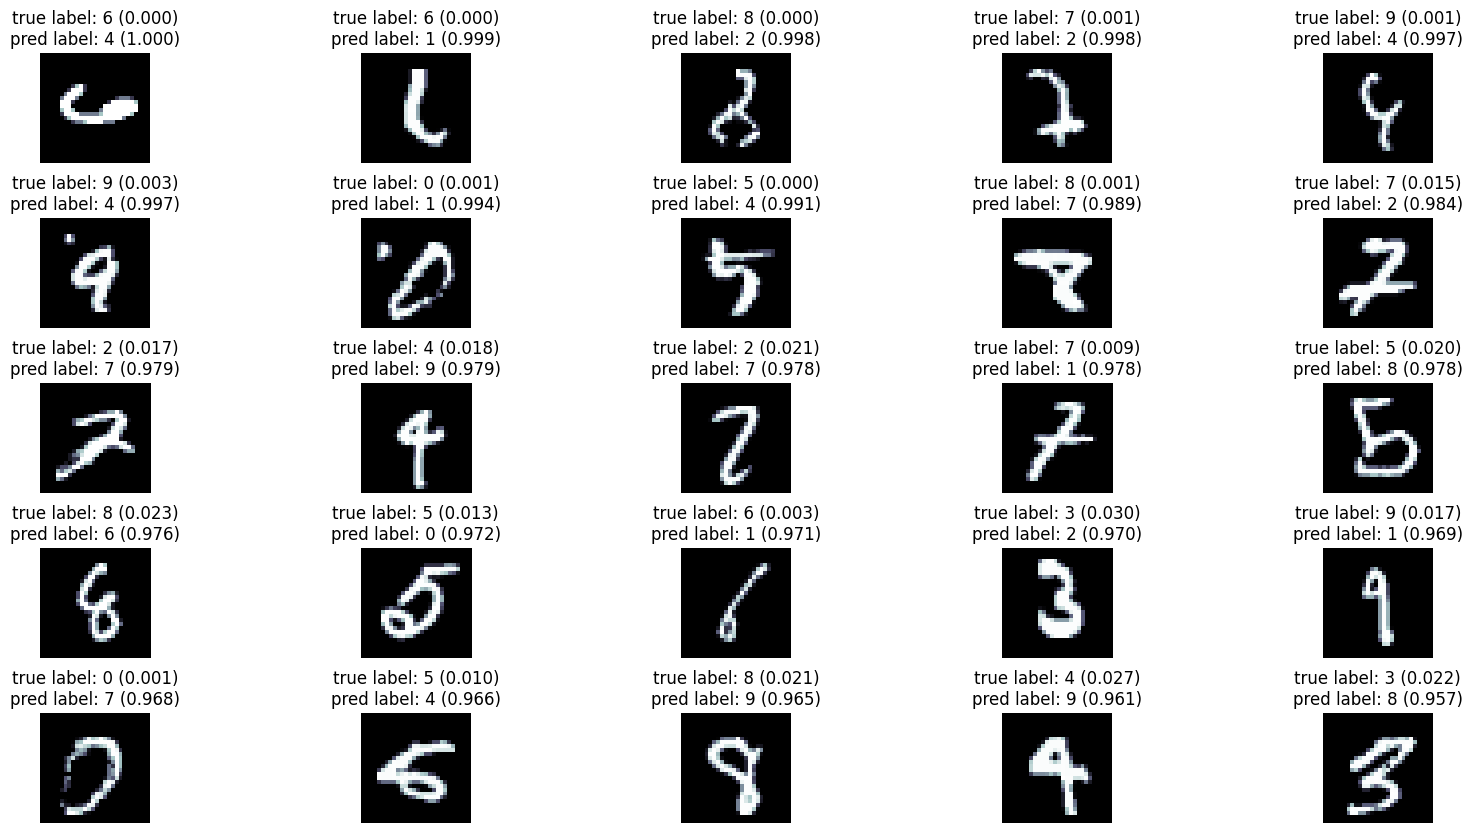

In [54]:
# 잘못 분류된 샘플들
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)

In [55]:
def get_representations(model, iterator, device):
    model.eval()
    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x,y) in tqdm(iterator):
            x = x.to(device)
            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
    # 최종 출력값
    outputs = torch.cat(outputs, dim=0)
    # 출력 직전의 레이어
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [56]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)

In [57]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components_ = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [58]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

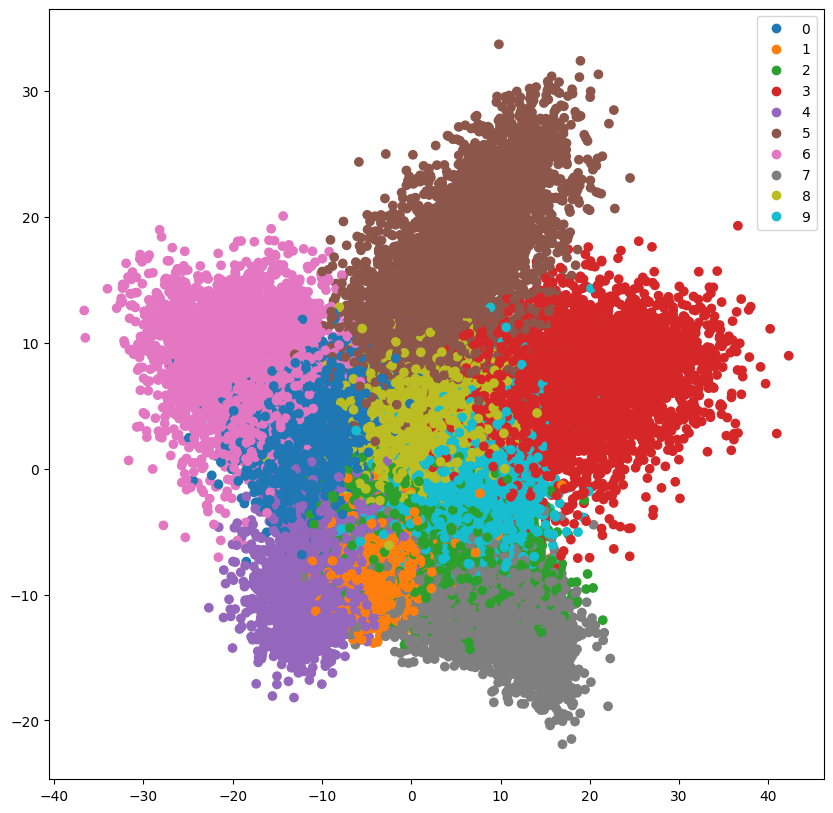

In [59]:
# 시각화를 위해 2차원으로 축소(주성분 분석)
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

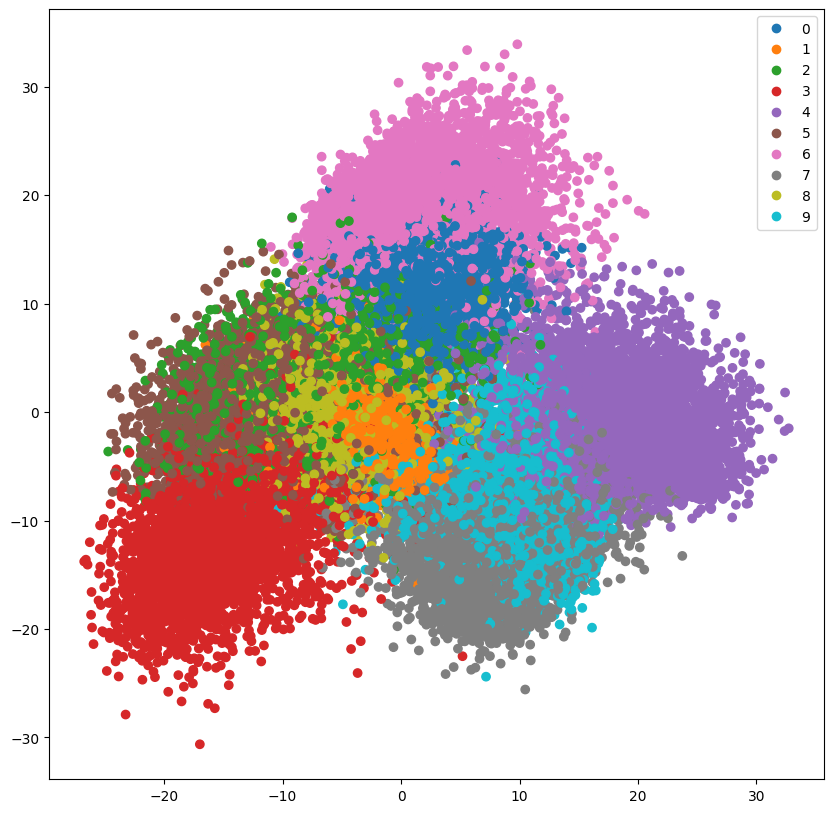

In [53]:
intermediates_pca_data = get_pca(intermediates) # 출력 직전의 layer
plot_representations(intermediates_pca_data, labels)

In [60]:
# 좀더 뚜렷하게 시각화하기 위해 t-SNE 사용

# t-SNE (t-distributed stochastics neighbor embedding)
#           t-분포      확률론적    이웃        임베딩
# 거리가 가까운 데이터는 가깝게, 거리가 먼 데이터는 멀리 떨어뜨리는 알고리즘
# t-분포: 자유도 = 표본수 - 1
# 자유도가 30 이하이면 표준 정규분포보다 평펴하고, 30이 넘으면 표준 정규분포와 비슷, 120 이상이 되면 표준 정규분포와 완전히 같아짐
# 자유도 : 표본 집단에서 모집단에 대한 정보를 주는 독립적인 자료의수
# 5개의 값으로 이뤄진 표본에서 평균과 4개의 값을 알고있다면?
# 데이터 : 2,1,3,5,x 평균 5.5 
# 자유도는 ? 4( =5-1)

In [62]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


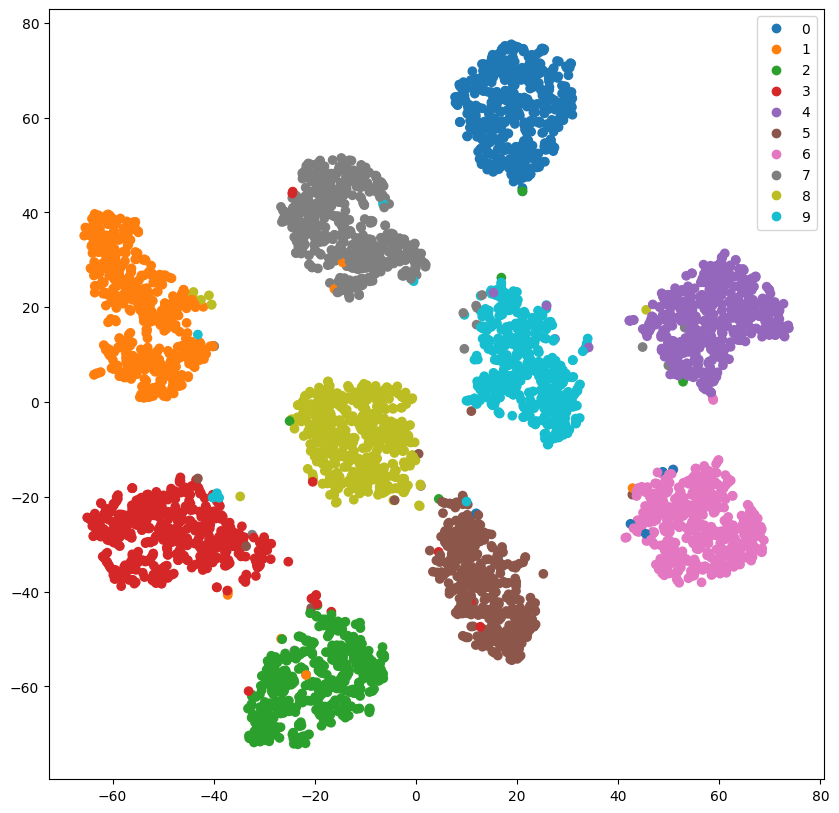

In [63]:
N_IMAGES = 5000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)
# 좀 더 뚜렷하게 나누어짐

c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


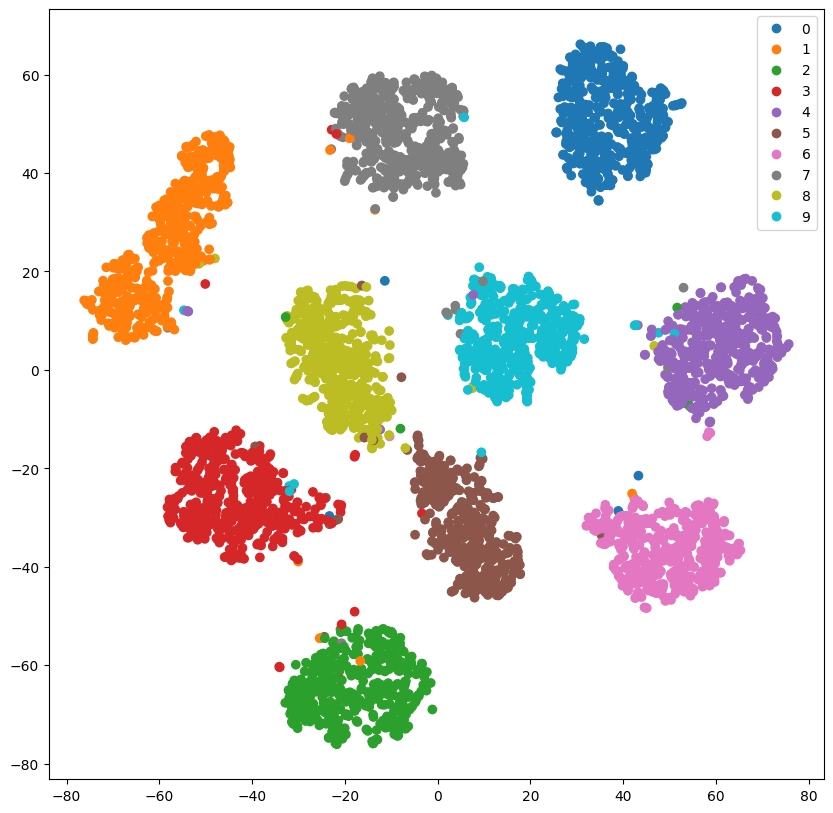

In [65]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)